In [1]:
import os
import sys
sys.path.append('..')
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvelo as scv
from pathlib import Path
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn import metrics
from scipy.sparse import csr_matrix
import multiprocessing as mp

from GraphCVAE import GraphCVAE
from Running import run

# Set environment variable for CUDA device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

2024-08-14 07:32:51.991435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 07:32:52.010828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 07:32:52.016643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 07:32:53.046619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = "/data/10XVisium/" #### to yo ur path
data_name = "Human Colon Cancer" #### project name 
save_path = "/data/GraphCVAE copy/Results" #### save path
file_fold = str(data_path) + str(data_name) #please replace 'file_fold' with the download path

In [3]:
deepen = run(save_path = save_path)
###### Read in 10x Visium data, or user can read in themselves.
adata = deepen._get_adata(platform="Visium", data_path=data_path, data_name=data_name)
###### Segment the Morphological Image


In [5]:
adata = deepen._get_image_crop(adata, data_name=data_name) 

Tiling image:   0%|           [ time left: ? ]

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]  


In [6]:
adata = deepen._get_augment(adata, spatial_type="KDTree", use_morphological=True)


Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
Morphological similarity calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Step 1: Augment molecule expression is Done!


In [7]:
augment_sparse = csr_matrix(adata.obsm['augment_gene_data'])
adata.X = augment_sparse+adata.X


In [8]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/usr/lib/R'

In [9]:
n_clusters =  14


In [10]:
adata_aug=adata

In [11]:
# define model
model = GraphCVAE(adata_aug, device=device,epochs=1200,n_top_genes=2000)

# train model
adata_aug = model.train()

Begin to train ST data...


100%|██████████| 1200/1200 [03:27<00:00,  5.79it/s]


Optimization finished for ST data!


In [12]:
# set radius to specify the number of neighbors considered during refinement
radius =30
tool = 'mclust' # mclust, leiden, and louvain
# clustering
from utils import clustering
if tool == 'mclust':
   clustering(adata_aug, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata_aug, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


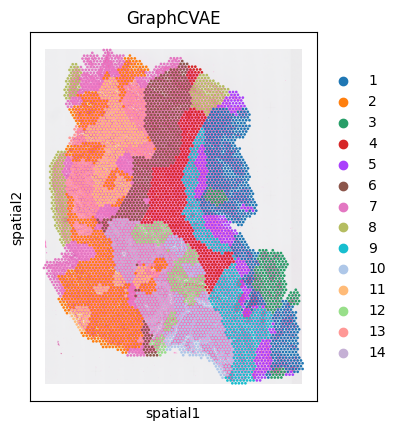

In [14]:
# plotting spatial clustering result
sc.pl.spatial(adata_aug,
              img_key="hires",
              color=["domain"],
              title=["GraphCVAE"],
              show=True,
              spot_size=300)